# Plot summary gougeevent traces

This notebook plots the gouge-mediated event traces associated with fb03-087.

2023.10.23 Kurama Okubo

2024.02.10 update for the master plot: corrected M0 and M0hat

2024.10.31 update for the merged catalog.


In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from multiprocessing import Pool, cpu_count
from obspy.signal.cross_correlation import correlate, xcorr_max

from itertools import combinations

from scipy.spatial.distance import euclidean, correlation

from matplotlib.patches import Rectangle, Circle, Ellipse

%reload_ext autoreload
%autoreload 2

from AEevents_Gridsearch_PS_func import *
from AEevents_plot_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
# rootdir for removal resp analysis
rootdir = "./"

# Event location
eventloc_table = "../data/datacsv/AE_obs_location.csv"

# output datadir
data_inputdir = "../data/07_DATA_MTinversion"

# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event location table
datadir = f"../data/06_assemble_gf_model{balldrop_model}"

# Path to the best fit source parameters
bestfitsourceparam_finame = "../data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"


In [3]:
figdir = "../figure/plot_summary_traces"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:
# read event loc
df_eventloc = pd.read_csv(eventloc_table, index_col=0)
df_eventloc["Z"] = 0
df_eventloc["datacase"] = df_eventloc.apply(lambda row: "{}__{:04d}".format(row.exprID, row.name), axis=1)
datacases = df_eventloc["datacase"].values
df_eventloc

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best,Z,datacase
gougeevent_id,,,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0000,-0.0002,0,fb03-087__0004
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0009
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0018
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0000,0.0000,0,fb03-087__0019
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0000,0.0010,0,fb03-087__0020
21,10,fb03-087,63.752300,1.7470,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0021
24,11,fb03-087,66.186944,1.7420,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0024
27,14,fb03-087,76.018478,1.7460,0.00245,6200,3600,0.0000,0.0002,0,fb03-087__0027
30,15,fb03-087,79.319850,1.7505,0.01000,6200,3600,0.0000,0.0000,0,fb03-087__0030


In [5]:
# load best parameters
df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0)
df_bestparam.head()

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.89,0.57,3.3,0
fb03-087__0009,0.73,0.05,3.1,0
fb03-087__0018,0.87,0.61,3.5,0
fb03-087__0019,0.79,0.05,3.1,0
fb03-087__0020,0.89,0.77,3.3,0


In [6]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

## Plot locations of gouge patch and slip sensor with ID

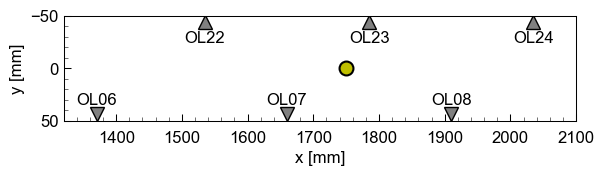

In [7]:
isslipsensor = False
iseventloc = False

left = 0 #[mm]
bottom = -50 #[mm]
width = 4100 #[mm]
height = 100 #[mm]

if iseventloc:
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    aspect_ratio = 0.5#6.7 # aspect ratio of rectangular plot
    ms = 28
else:
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    aspect_ratio = 2*0.8 #6.7 # aspect ratio of rectangular plot
    ms = 10
    
rect = Rectangle((left, bottom), width, height, fill=True, color='white')

ax.add_patch(rect)

# plot location of gaugepatch 
gaugepatch_locs_x = [750, 1250, 1750, 2250, 2750, 3250, 3750]
gaugepatch_locs_y = np.zeros(len(gaugepatch_locs_x))

ax.plot(gaugepatch_locs_x, gaugepatch_locs_y, "o", markersize=ms, color='y', mew=1.5, mec="k") 

# plot relocated foreshock events
if iseventloc:
    for index, df_tmp in df_eventloc.iterrows():
        eventloc_x = df_tmp["X"]*1e3
        eventloc_y = df_tmp["Y"]*1e3
        ax.plot(eventloc_x, eventloc_y, "x", markersize=12, color='k', mew=1.5, mec="k") 


# plot location of stations
if not iseventloc:
    for stnm in channel_loc:
        x1 = channel_loc[stnm][0]
        y1 = channel_loc[stnm][1]
        z1 = channel_loc[stnm][2]
        # upper side
        if y1 >0:
            ax.plot(x1, y1-6, marker='v', markersize=ms, color='gray', mec='k')
            ax.text(x1, y1-15, stnm, ha='center', clip_on=True)
            
        elif y1 < 0:
            ax.plot(x1, y1+6, marker='^', markersize=ms, color='gray', mec='k')
            ax.text(x1, y1+26, stnm, ha='center', clip_on=True)

            
        ax.set_yticks([-50, 0, 50])


# plot location of slip sensor
if isslipsensor:
    for i in range(16):
        ax.plot(slip_x[i], +45, marker='s', markersize=8, color="#DC143C", mec='k') 
        ax.text(slip_x[i], +40, f"GAP{i+1:02d}", ha='left', va="bottom", clip_on=True)

# if iseventloc:
#     ax.set_xlim(1700, 1800)
# else:
# #     ax.set_xlim(left, width)

ax.set_xlim(1320, 2100)

ax.set_ylim(bottom, height/2)
ax.set_aspect(aspect_ratio)
plt.gca().invert_yaxis()
ax.tick_params(axis='x', which='major', pad=7)
ax.tick_params(axis='both', which='major')

fig.tight_layout()
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
plt.savefig(figdir+f"/gaugepatch_locations_wslipsensor_slipsensor{isslipsensor}_eventloc{iseventloc}_patchzoomed.png", format="png", dpi=150, bbox_inches="tight")
plt.savefig(figdir+f"/gaugepatch_locations_wslipsensor_slipsensor{isslipsensor}_eventloc{iseventloc}_patchzoomed.eps", format="eps", dpi=150, bbox_inches="tight")


## Plot hypocenter of events

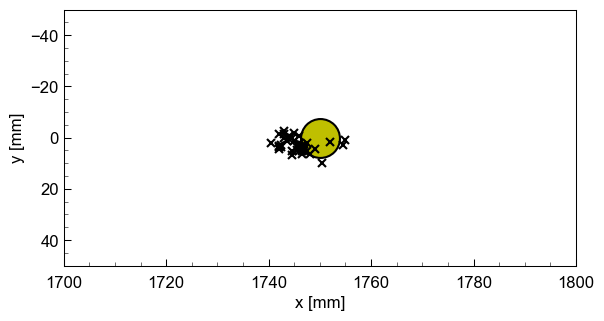

In [8]:
isslipsensor = False
iseventloc = True

left = 0 #[mm]
bottom = -50 #[mm]
width = 4100 #[mm]
height = 100 #[mm]

if iseventloc:
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    aspect_ratio = 0.5#6.7 # aspect ratio of rectangular plot
    ms = 28
else:
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    aspect_ratio = 2*0.8 #6.7 # aspect ratio of rectangular plot
    ms = 10
    
rect = Rectangle((left, bottom), width, height, fill=True, color='white')

ax.add_patch(rect)

# plot location of gaugepatch 
gaugepatch_locs_x = [750, 1250, 1750, 2250, 2750, 3250, 3750]
gaugepatch_locs_y = np.zeros(len(gaugepatch_locs_x))

ax.plot(gaugepatch_locs_x, gaugepatch_locs_y, "o", markersize=ms, color='y', mew=1.5, mec="k") 

# plot relocated foreshock events
if iseventloc:
    for index, df_tmp in df_eventloc.iterrows():
        eventloc_x = df_tmp["X"]*1e3
        eventloc_y = df_tmp["Y"]*1e3
        ax.plot(eventloc_x, eventloc_y, "x", markersize=6, color='k', mew=1.5, mec="k") 


# plot location of stations
if not iseventloc:
    for stnm in channel_loc:
        x1 = channel_loc[stnm][0]
        y1 = channel_loc[stnm][1]
        z1 = channel_loc[stnm][2]
        # upper side
        if y1 >0:
            ax.plot(x1, y1-6, marker='v', markersize=ms, color='gray', mec='k')
            ax.text(x1, y1-15, stnm, ha='center', clip_on=True)
            
        elif y1 < 0:
            ax.plot(x1, y1+6, marker='^', markersize=ms, color='gray', mec='k')
            ax.text(x1, y1+26, stnm, ha='center', clip_on=True)

            
        ax.set_yticks([-50, 0, 50])


# plot location of slip sensor
if isslipsensor:
    for i in range(16):
        ax.plot(slip_x[i], +45, marker='s', markersize=8, color="#DC143C", mec='k') 
        ax.text(slip_x[i], +40, f"GAP{i+1:02d}", ha='left', va="bottom", clip_on=True)

if iseventloc:
    ax.set_xlim(1700, 1800)
else:
    ax.set_xlim(left, width)

# ax.set_xlim(1400, 2100)

ax.set_ylim(bottom, height/2)
ax.set_aspect(aspect_ratio)
plt.gca().invert_yaxis()
ax.tick_params(axis='x', which='major', pad=7)
ax.tick_params(axis='both', which='major')

fig.tight_layout()
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
plt.savefig(figdir+f"/gaugepatch_locations_wslipsensor_slipsensor{isslipsensor}_eventloc{iseventloc}_patchzoomed.png", format="png", dpi=150, bbox_inches="tight")
plt.savefig(figdir+f"/gaugepatch_locations_wslipsensor_slipsensor{isslipsensor}_eventloc{iseventloc}_patchzoomed.eps", format="eps", dpi=150, bbox_inches="tight")


# 2. Plot fitting traces

In [9]:
print("The list of avilable events:")
for i, s in enumerate(datacases):
    print(i, s)

The list of avilable events:
0 fb03-087__0004
1 fb03-087__0009
2 fb03-087__0018
3 fb03-087__0019
4 fb03-087__0020
5 fb03-087__0021
6 fb03-087__0024
7 fb03-087__0027
8 fb03-087__0030
9 fb03-087__0031
10 fb03-087__0037
11 fb03-087__0038
12 fb03-087__0040
13 fb03-087__0043
14 fb03-087__0044
15 fb03-087__0049
16 fb03-087__0050
17 fb03-087__0052
18 fb03-087__0055
19 fb03-087__0059
20 fb03-087__0061
21 fb03-087__0062
22 fb03-087__0069
23 fb03-087__0072
24 fb03-087__0075
25 fb03-087__0076
26 fb03-087__0077
27 fb03-087__0081
28 fb03-087__0085
29 fb03-087__0088
30 fb03-087__0089
31 fb03-087__0095
32 fb03-087__0099
33 fb03-087__0100
34 fb03-087__0102
35 fb03-087__0109
36 fb03-087__0110
37 fb03-087__0111
38 fb03-087__0118
39 fb03-087__0120
40 fb03-087__0126
41 fb03-087__0128
42 fb03-087__0129
43 fb03-087__0131


In [10]:
## Plot single event

start processing event fb03-087__0072.
aperture correct: OL07 incident angle=67.981519deg. beta_p=0.643465
aperture correct: OL08 incident angle=75.801249deg. beta_p=0.615045
aperture correct: OL23 incident angle=55.454324deg. beta_p=0.710372
aperture correct: OL22 incident angle=76.132287deg. beta_p=0.614098
9e-07
8e-07
3e-07
-2e-07


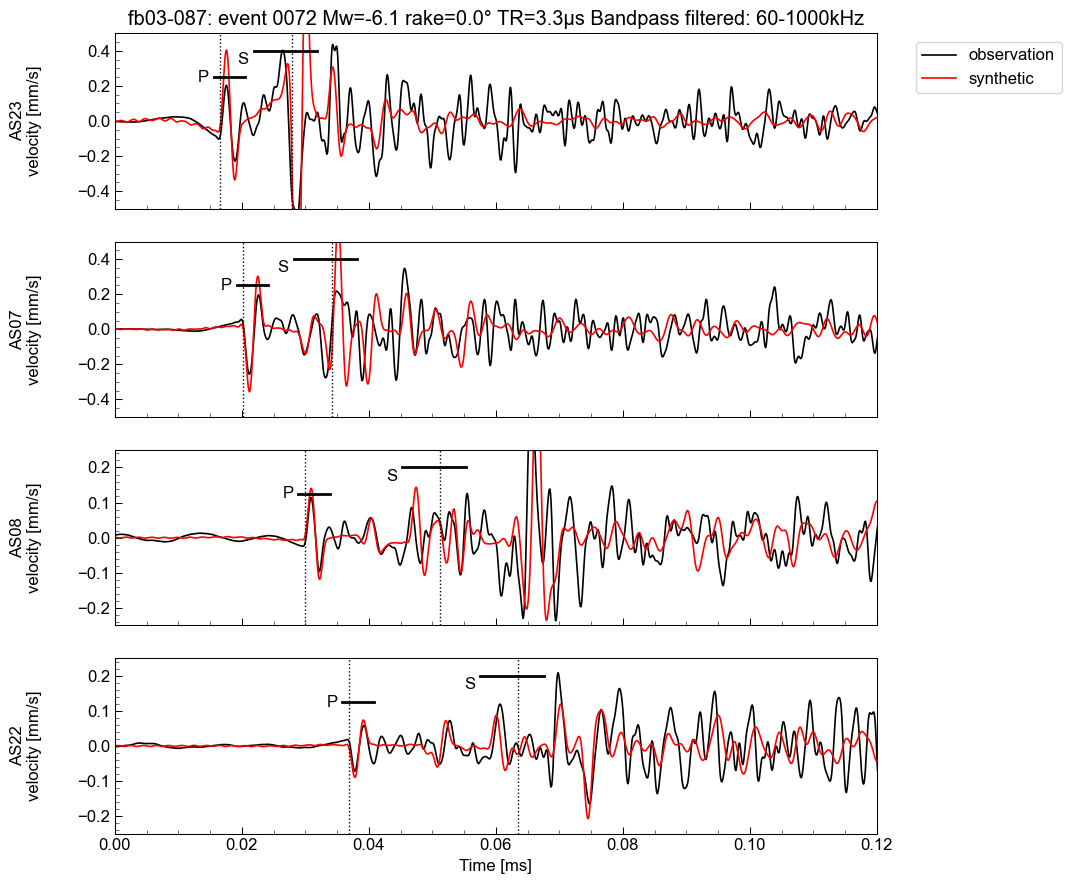

In [11]:
# select event
# for datacase in datacases:
datacase = datacases[23] # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
print(f"start processing event {datacase}.")

# load event trace
st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance

# load parameter file
with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacase, balldrop_model),"rb") as fo:
    param = pickle.load(fo)

# param['df_dist_sorted'].pop("OL06") # remove the farthest sensor due to low coherence

# param["freqmax"] = 2e6


M0_best = df_bestparam[df_bestparam.index==datacase]["M0_best"][0]
TR_best = df_bestparam[df_bestparam.index==datacase]["TR_best"][0]
rake_best = df_bestparam[df_bestparam.index==datacase]["rake_best"][0]
M0hat_best = M0_best*np.sqrt(2) # Note: this is used to synthesize the best fit traces
# Compute synthesized waveform with best parameters
# st_event_trimmed = get_retrimmed_traces(M0hat_best, rake_best, TR_best*1e-6, param)
st_event_trimmed = get_retrimmed_traces(M0hat_best, rake_best, TR_best*1e-6, param, fix_dtshift=False, aperturecorrection=param["aperturecorrection"])

f"{datacase.split('__')[0]}: event {datacase.split('__')[1]:s}"

# plot comparison of waveform
# NOTE: tr_filt includes pretigger, while tr_retrimmed is retrimmed without pretigger. Thus, correct pretrigger only on the filter (entire) trace.
# pwin_st, pwin_et does not contain the pretrigger. 

#-----------------#
# Plot full-waveform fitting with best parameters
#-----------------#

# set ylim
param["ylim"] = [0.5, 0.5, 0.25, 0.25, 0.1, 0.1]

param["M0"] = M0_best
param["Mw"] = M02Mw(M0_best)
param["TR"] = TR_best*1e-6
param["rake"] = rake_best
param["gougeevent_id"] = f"{datacase.split('__')[0]}: event {datacase.split('__')[1]:s}"

param["plot_reflection"] = False
# AE_GridSearch_plot_raw_noshift(st_event_trimmed, param)
AE_GridSearch_plot_raw(st_event_trimmed, param) # plot with time shifting using the P wave correlation

plt.tight_layout()
plt.savefig(figdir + "/waveform_raw_{}_reflection_{}.png".format(datacase, param["plot_reflection"]), dpi=300)

In [12]:
# st_event.select(location="stage1",channel="OZ")

## Plot the entire traces and P window

1. Timeshift the entire trace with P wave correlation
2. Note the info about the source distance and incident angle

In [13]:
param['aperturecorrection']
param

{'datacase': 'fb03-087__0072',
 'st_event': 60 Trace(s) in Stream:

FB.OL06.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
...
(58 other traces)
...
OL.OL24.GF.G_Vz_mzz | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces],
 'TR_input': 5e-06,
 'cp': 6200,
 'cs': 3600,
 'weight_factor': 0.1,
 'prePwinlen': 0.001,
 'Pwinlen': 0.004,
 'preSwinlen': 0.006,
 'Swinlen': 0.004,
 'compute_P': True,
 'compute_S': True,
 'alpha_p': 1.0,
 'alpha_s': 0.0,
 'ifFilteringBeforeTrim': True,
 'freqmin': 60000.0,
 'freqmax': 1000000.0,
 'max_lag_shift': 51,
 'aperturecorrection': True,
 'VR_sensors': ('OL07', 'OL08', 'OL23', 'OL22'),
 'df_incidentangle':                         OL        datacase     xs    ys    zs      xi  \
 OL06__fb03-087__0004  OL06  fb03-087__0004  1.370  0.05  0.07  1.7475   
 OL06__fb03-087__0009  OL06  fb03-087__0009 

In [14]:
param['df_dist_sorted']['OL23']

96.99097896196325

In [15]:
param["df_incidentangle"].loc[f"{'OL23'}__{param['datacase']}"]

OL                           OL23
datacase           fb03-087__0072
xs                          1.785
ys                          -0.05
zs                           0.07
xi                         1.7465
eta                         0.005
zeta                            0
xi1                        0.0385
eta1                       -0.055
zeta1                           0
incidentangle           55.454324
azimuth                  34.99202
rlen_sourcedist          0.096991
llen                     0.067136
Name: OL23__fb03-087__0072, dtype: object

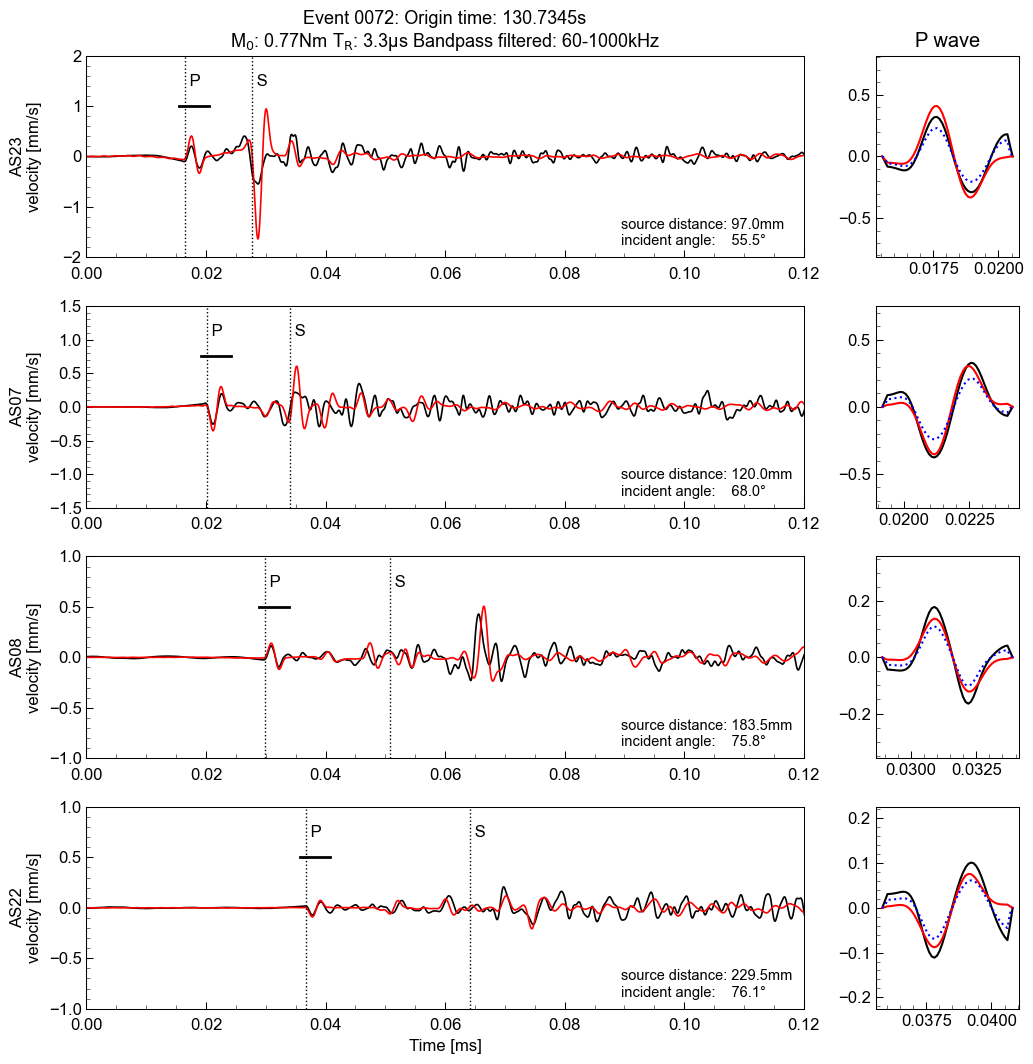

In [16]:
# #-----------------#
# # Plot P shifted
# #-----------------#

# plot shifted traces
param["cc_threshold"] = 0.5
param["ylim"] = [2, 1.5, 1, 1] #[0.6, 0.35, 0.2, 0.15, 0.09]

AE_GridSearch_plot_entirewaveform_withP(st_event_trimmed, param)
plt.tight_layout()
plt.savefig(figdir + "/waveform_withPwindow_masterplot_{}.jpg".format(datacase), dpi=80)
plt.savefig(figdir + "/waveform_withPwindow_masterplot_{}.pdf".format(datacase))
# plt.clf()
# plt.close()

In [17]:
datacases[5]

'fb03-087__0021'

## Plot all traces

**Need to run after running the 07_2 all events in desktop macmini.**

In [18]:
# select event
for datacase in datacases:
    if datacase == 'fb03-087__0030':
        print(f"skip {datacase}.") # skip the event for master plot
        continue
        
    # datacase = datacases[4] # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
    print(f"start processing event {datacase}.")

    # load event trace
    st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance

    # load parameter file
    with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacase, balldrop_model),"rb") as fo:
        param = pickle.load(fo)


    # param['df_dist_sorted'].pop("OL06") # remove the farthest sensor due to low coherence

    M0_best = df_bestparam[df_bestparam.index==datacase]["M0_best"][0]
    TR_best = df_bestparam[df_bestparam.index==datacase]["TR_best"][0]
    rake_best = df_bestparam[df_bestparam.index==datacase]["rake_best"][0]

    # Compute synthesized waveform with best parameters
    st_event_trimmed = get_retrimmed_traces(M0_best, rake_best, TR_best*1e-6, param)

    f"{datacase.split('__')[0]}: event {datacase.split('__')[1]:s}"

    # plot comparison of waveform
    # NOTE: tr_filt includes pretigger, while tr_retrimmed is retrimmed without pretigger. Thus, correct pretrigger only on the filter (entire) trace.
    # pwin_st, pwin_et does not contain the pretrigger. 

    #-----------------#
    # Plot full-waveform fitting with best parameters
    #-----------------#

    # set ylim
    param["ylim"] = [1.5, 0.7, 0.5, 0.5, 0.2]

    param["M0"] = M0_best
    param["Mw"] = M02Mw(M0_best)
    param["TR"] = TR_best*1e-6
    param["rake"] = rake_best
    param["gougeevent_id"] = f"{datacase.split('__')[0]}: event {datacase.split('__')[1]:s}"

    param["plot_reflection"] = False
    # AE_GridSearch_plot_raw_noshift(st_event_trimmed, param)
    AE_GridSearch_plot_raw(st_event_trimmed, param) # plot with time shifting using the P wave correlation

    plt.tight_layout()
    # plt.savefig(figdir + "/waveform_raw_{}_reflection_{}.png".format(datacase, param["plot_reflection"]), dpi=400)
    plt.clf()
    plt.close()
    
    #-----------------#
    # Plot PS shifted
    #-----------------#
    # plot shifted traces
    param["cc_threshold"] = 0.5
    del param['ylim'] # set the ylim automatically
    
    AE_GridSearch_plot_entirewaveform_withP(st_event_trimmed, param)

    plt.tight_layout()
    # plt.savefig(figdir + "/waveform_withPwindow_{}.png".format(datacase), dpi=300)
    plt.savefig(figdir + "/waveform_withPwindow_{}.jpg".format(datacase), dpi=80)
    plt.clf()
    plt.close()

start processing event fb03-087__0004.
8e-07
7e-07
2e-07
-3e-07
start processing event fb03-087__0009.
0.0
1e-07
-7e-07
-8e-07
start processing event fb03-087__0018.
7e-07
5e-07
-1e-07
-4e-07
start processing event fb03-087__0019.
2e-07
0.0
-7e-07
-8e-07
start processing event fb03-087__0020.
8e-07
6e-07
0.0
-2e-07
start processing event fb03-087__0021.
1e-07
1e-07
-7e-07
-8e-07
start processing event fb03-087__0024.
2e-07
3e-07
-6e-07
-6e-07
start processing event fb03-087__0027.
1e-06
7e-07
0.0
0.0
skip fb03-087__0030.
start processing event fb03-087__0031.
8e-07
1.4e-06
2e-07
3e-07
start processing event fb03-087__0037.
-1.1e-06
1.6e-06
-3.2999999999999997e-06
2.3e-06
start processing event fb03-087__0038.
1e-06
8e-07
2e-07
0.0
start processing event fb03-087__0040.
9e-07
4e-07
0.0
-4e-07
start processing event fb03-087__0043.
7e-07
2e-07
0.0
-8e-07
start processing event fb03-087__0044.
1.1e-06
4e-07
-3e-07
0.0
start processing event fb03-087__0049.
3e-07
3e-07
2.3e-06
2.4e-06
star